# Project: ML - Liner Regression, Significance Testing (Tower of Pisa)

<br>

## Questions to address:
- Predict lean vs year for the tower of Pisa

<br>

## Tools:
- Models:
  - Linear Regression with statsmodels OLS
- Error Metric: SSE, RSS, TSS, R2
- Student-t test for significance of lean pending on year

<br>

### load defaults

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import requests 

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams
import matplotlib.dates as mdates
from datetime import datetime
from IPython.display import display, Math

from functions import *

plt.rcParams.update({'axes.titlepad': 20, 'font.size': 12, 'axes.titlesize':20})

colors = [(0/255,107/255,164/255), (255/255, 128/255, 14/255), 'red', 'green', '#9E80BA', '#8EDB8E', '#58517A']
Ncolors = 10
color_map = plt.cm.Blues_r(np.linspace(0.2, 0.5, Ncolors))
#color_map = plt.cm.tab20c_r(np.linspace(0.2, 0.5, Ncolors))


#specific to this project
import statsmodels.api as sm
from scipy.stats import t #student-t distributions


print("Defaults Loaded")

Defaults Loaded


<br>

## Dataset:  inclination of tower of Pisa

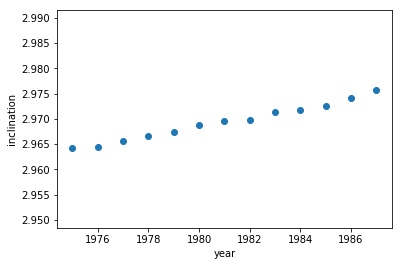

In [3]:
pisa = pd.DataFrame({"year": range(1975, 1988), 
                         "lean": [2.9642, 2.9644, 2.9656, 2.9667, 2.9673, 2.9688, 2.9696, 
                                  2.9698, 2.9713, 2.9717, 2.9725, 2.9742, 2.9757]})

plt.scatter(pisa['year'], pisa['lean'])
plt.xlabel("year"), plt.ylabel("inclination")
plt.show()

<br>

## Ordinary Least Squares

In [4]:
y = pisa.lean # target
X = pisa.year  # features
#sm doesn't automatically include an intercept
X = sm.add_constant(X)  # add a column of 1's as the constant term

# OLS -- Ordinary Least Squares Fit
linear = sm.OLS(y, X)
# fit model
linearfit = linear.fit()

print("\n",linearfit.params)


 const    1.123338
year     0.000932
dtype: float64


check if residuals are gaussian distributed

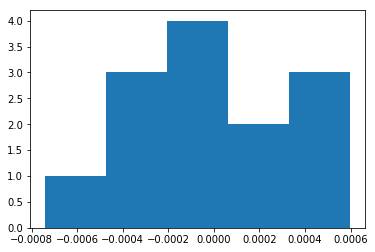

In [5]:
yhat = linearfit.predict(X)
residuals = yhat-y
plt.hist(residuals, bins=5)
plt.show()

hard to check because we only have 13 observations

<br>

### Error Metric for Linear Regression Models:
- Sum of Square Error (SSE) = $\sum_{i=1}^n(y_i-\hat{y}_i)^2=\sum_{i=1}^ne_i^2$ (sum of all residuals)
- Regression Sum of Squares (RSS) = $\sum_{i=1}^n(\bar{y}-\hat{y}_i)^2$ where $\overline{y}=\frac{1}{n}\sum_{i=1}^ny_i$ (measures amount of explained variance, 0 if all predictions=mean)
- Total Sum of Squares (TSS = RSS+SSE) = $\sum_{i=1}^n(y_i-\bar{y})^2$ (measures total amount of variation in the data)

In [6]:
SSE = np.sum((y.values-yhat)**2)
RSS = np.sum((np.sum(y.values)/len(y)-yhat)**2)
TSS = np.sum((y.values-np.sum(y.values)/len(y))**2)

print("SSE = {:0.4g} \nRSS = {:0.4g} \nTSS = {:0.4g}".format(SSE, RSS, TSS))

SSE = 1.923e-06 
RSS = 0.000158 
TSS = 0.00016


<br>

### Error Metric: R-Squared (coefficient of determination), percentage of variation in the target variable present in our model
- $R^2 = 1-\frac{SSE}{TSS}=\frac{RSS}{TSS}$

In [7]:
R2 = RSS/TSS
print("R2 = {:0.4g}".format(R2))

R2 = 0.988


our model accounts for almost all variatin in the data

In [8]:
#predict displacement in 15 years
delta = linearfit.params['year']*15
print(delta)

0.013978021978021324


<br>

### Variance of Coefficients: expected range in predicted coefficients
- estimated variance for a linear model with 1 variable: $s^2\hat{\beta_1}=\frac{\sum_{i=1}^n(y_i-\hat{y}_i)^2}{(n-2)\sum_{i=1}^n(x_i-\bar{x})^2}=\frac{SSE}{(n-2)\sum_{i=1}^n(x_i-\bar{x})^2}$

In [9]:
X = pisa['year']

xvar = np.sum((X-X.mean())**2)
s2b1 = SSE / ((len(X)-2) * xvar)
print("s2b1 = {:0.4g}".format(s2b1))

s2b1 = 9.605e-10


<br>

### Summary of Error Metrics:

In [10]:
print(linearfit.summary())

                            OLS Regression Results                            
Dep. Variable:                   lean   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     904.1
Date:                Sat, 05 Jan 2019   Prob (F-statistic):           6.50e-12
Time:                        14:40:39   Log-Likelihood:                 83.777
No. Observations:                  13   AIC:                            -163.6
Df Residuals:                      11   BIC:                            -162.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1233      0.061     18.297      0.0

/Users/BrunoHenriques/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))


<br>

### Student t-test for significance testing
- t-distribution is similar to gaussian but with lower peak (approaces gaussian for large samples)
- t-distribution takes into account finite samples (increased variance in smaller samples)
- null hypothesis: lean doesn't depend on year, coefficient equal 0 
- $H_0:\beta_1=0 \; H_1:\beta_1 \neq0$
- test null hypothesis: $t=\frac{|\hat{\beta_1}-0|}{\sqrt{s^2(\hat{\beta_1})}}$
  - how many standard deviations the coefficient is from 0, if $\beta_1$ is far from 0 with low variance t is high (from the plot a t-stat far from 0 has very low probability)

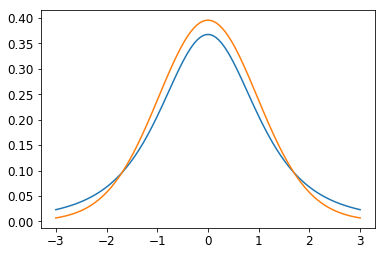

In [15]:
x = np.linspace(-3,3,100)

# Compute the pdf with 3 degrees of freedom (student-t distributions)
tdist3 = t.pdf(x=x, df=3)
# Compute the pdf with 30 degrees of freedom (student-t distributions)
tdist30 = t.pdf(x=x, df=30)

plt.plot(x, tdist3)
plt.plot(x, tdist30)
plt.show()

In [13]:
tstat = linearfit.params["year"]/np.sqrt(s2b1)
print(tstat)

30.068584687651178


<br>

test our t-stat: 95% confidence level that $\beta_1$ is not 0. Compute cdf at the given p-value (95%) and degrees of freedom and compute probability
- test for negative or positive $\beta_1$ (2.5 and 97.5 percentiles of distribution)
- since t-distribution is symmetrical we can take |t-stat| and look at the 97.5 percentile
- if $Tcdf(|t|,df)<0.975$: accept $H_0: \beta_1=0$
- else: accept $H_1$

In [14]:
# At the 95% confidence interval for a two-sided t-test we must use a p-value of 0.975
pval = 0.975

# The degrees of freedom
df = pisa.shape[0] - 2

# The probability to test against
p = t.cdf(abs(tstat), df=df)

beta1_test = pval<p
print("pval = {:0.3f} \nt-stat prob = {:0.3f} \nHypothesis = {}".format(pval, p, beta1_test))

pval = 0.975 
t-stat prob = 1.000 
Hypothesis = True
